<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.855 · Modelos avanzados de minería de datos · PEC2</p>
<p style="margin: 0; text-align:right;">2021-1 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PEC 2: Métodos no supervisados

A lo largo de esta práctica veremos como aplicar distintas técnicas no supervisadas
así como algunas de sus aplicaciones reales:

 - **[Clustering con distintas estrategias](#ej1)**: k-means y regla del codo, basadas en densidad y jerárquicas.
 - **[Aplicación: generación de imágenes con reducción de dimensionalidad](#ej2)**. PCA y UMAP.
 - **[Aplicación: identificación de puntos de interés turísticos](#ej3)**.

<div class="alert alert-block alert-info">
<strong>Nombre y apellidos:</strong>
</div>

<font color=#679532>José Javier Gómez de Diego

---

Para ello vamos a necesitar las siguientes librerías:

In [1]:
import random

import umap
import numpy as np
import pandas as pd
import sklearn
from sklearn import cluster        # Algoritmos de clustering.
from sklearn import datasets       # Crear datasets.
from sklearn import decomposition  # Algoritmos de reduccion de dimensionalidad.

# Visualizacion.
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

<a id="ej1"></a>

## 1. Métodos de *clustering* (4 puntos)

Este ejercicio trata de explorar distintas técnicas de agrupamiento ajustándolas a distintos conjuntos de datos.

El objetivo es doble: entender la influencia de los parámetros en su comportamiento, y conocer sus limitaciones en la búsqueda de estructuras de datos.

### Generación de los conjuntos de datos

In [2]:
X_blobs, y_blobs = datasets.make_blobs(n_samples=1000, n_features=2, centers=4, cluster_std=1.6, random_state=42)
X_moons, y_moons = datasets.make_moons(n_samples=1000, noise=.07, random_state=42)
X_circles, y_circles = datasets.make_circles(n_samples=1000, factor=.5, noise=.05, random_state=42)

Cada dataset tiene 2 variables: una variable *X* que contiene 2 features (columnas) y tantas filas como muestras. Y una variable *y* que alberga las etiquetas que identifican cada cluster.

A lo largo del ejercicio no se usará la variable *y* (sólo con el objetivo de visualizar). El objetivo es a través de los distintos modelos de *clustering* conseguir encontrar las estructuras descritas por las variables *y*.

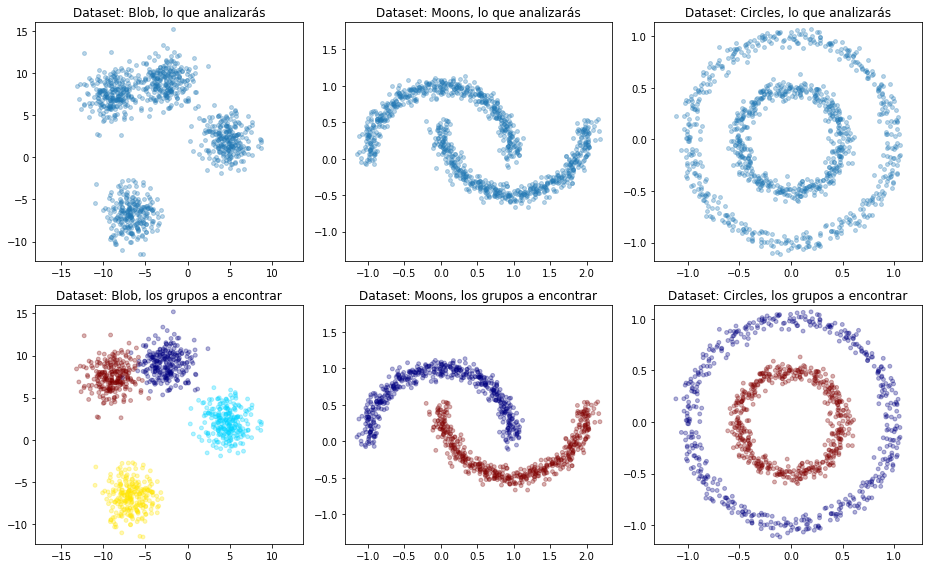

In [3]:
fig, axis = plt.subplots(2, 3, figsize=(13, 8))
for i, (X, y, ax, name) in enumerate(zip([X_blobs, X_moons, X_circles] * 2,
                                         [None] * 3 + [y_blobs, y_moons, y_circles],
                                         axis.reshape(-1),
                                         ['Blob', 'Moons', 'Circles'] * 2)):
    ax.set_title('Dataset: {}, '.format(name) + ('lo que analizarás' if i < 3 else 'los grupos a encontrar'))
    ax.scatter(X[:,0], X[:,1], s=15, c=y, alpha=.3, cmap='jet')
    ax.axis('equal')
plt.tight_layout()

### 1 a. K-means

En este apartado se pide probar el algoritmo *k-means* sobre los tres datasets presentados anteriormente ajustando con los parámetros adecuados y analizar sus resultados.

In [4]:
X, y = X_blobs, y_blobs

Para estimar el número de clusters a detectar por *k-means*. Una técnica para estimar $k$ es, como se explica en la teoría:
> Los criterios anteriores (minimización de distancias intra grupo o maximización de distancias inter grupo) pueden usarse para establecer un valor adecuado para el parámetro k. Valores k para los que ya no se consiguen mejoras significativas en la homogeneidad interna de los segmentos o la heterogeneidad entre segmentos distintos, deberían descartarse.

Lo que popularmente se conocer como *regla del codo*.

Primero es necesario calcular la suma de los errores cuadráticos ([*SSE*](https://bl.ocks.org/rpgove/0060ff3b656618e9136b)) que consiste en la suma de todos los errores (distancia de cada punto a su centroide asignado) al cuadrado.

$$SSE = \sum_{i=1}^{K} \sum_{x \in C_i} euclidean(x, c_i)^2$$

Donde $K$ es el número de clusters a buscar por *k-means*, $x \in C_i$ son los puntos que pertenecen a i-ésimo cluster, $c_i$ es el centroide del cluster $C_i$ (al que pertenece el punto $x$), y $euclidean$ es la [distancia euclídea](https://en.wikipedia.org/wiki/Euclidean_distance).

Este procedimiento realizado para cada posible valor $k$, resulta en una función monótona decreciente, donde el eje $x$ representa los distintos valores de $k$, y el eje $y$ el $SSE$. Intuitivamente se podrá observar un significativo descenso del error, que indicará el valor idóneo de $k$.

**Se pide realizar la representación gráfica de la regla del codo junto a su interpretación, utilizando la librería ```matplotlib``` y la implementación en scikit-learn de [*k-means*](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).**

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> cálculo y visualización de la regla del codo en el dataset Blobs.
</div>

In [5]:
# Normalizar
normalizar = sklearn.preprocessing.MinMaxScaler()
X = normalizar.fit_transform(X)

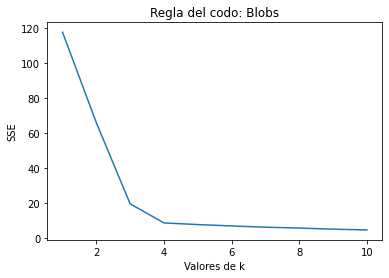

In [6]:
import warnings
warnings.filterwarnings('ignore')             # Ignorar warning de memoria de Widnows que salta al ejecutar el algoritmo k-means con k=1

sse = []
for i in np.arange(1,11):                     # Evaluar desde k=1 a k=10
    km = cluster.KMeans(n_clusters=i).fit(X)  # Instanciar K-means y ajustar
    sse.append(km.inertia_)                   # Calcular y registrar el error cuadrático de cada punto a su centroide más cercano

# Graficar
plt.title("Regla del codo: Blobs")
plt.xlabel("Valores de k")
plt.ylabel("SSE", rotation=90)
plt.plot(np.arange(1, 11), sse)
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué se interpreta en la gráfica? ¿Cómo podría mejorarse la elección de $k$?.  
</div>

<font color=#679532>A partir de *k*=3, el error cuadrático cae considerablemente; y a partir de *k*=4, **apenas decrece** para valores mayores de *k*. Debido a la gran mejora del error cuadrático en los valores de *k* más bajo, observando la gráfica cabría la duda de si la mejor opción de *k* es 3 o 4.

<font color=#679532>Para mejorar la elección de *k* se podría expresar en términos **porcentuales** la mejora del error cuadrático para un valor de *k* con respecto al valor de *k*-1:

[ 78.7 239.4 128.1  12.4  11.4  12.    8.7  13.1   9.5]


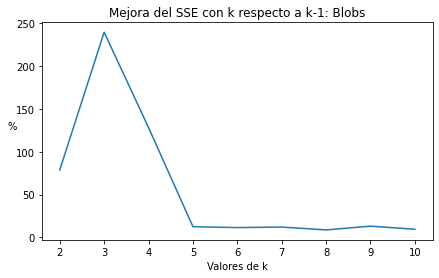

In [7]:
mejora = []
for i in np.arange(1, len(sse)):
    mejora.append(((sse[i-1]-sse[i])/sse[i])*100)  # Calcular y registrar el % de mejora

# Graficar
plt.figure(figsize=(7, 4))
plt.title("Mejora del SSE con k respecto a k-1: Blobs")
plt.xlabel('Valores de k')
plt.ylabel('%', rotation=0)
plt.plot(np.arange(2, 11), mejora)
print(np.around(mejora, 1))
plt.show()

<font color=#679532>De esta forma, se obtiene que *k*=4 mejora el error cuadrático un **108%**; y a partir de ahí, tan solo un 11% aprox. Por lo tanto, la elección de *k* es más intuitiva.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> cálculo y visualización de los grupos en el dataset Blobs.
</div>

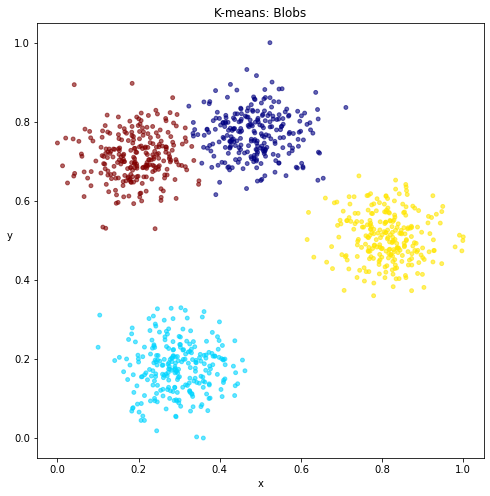

In [8]:
k = 4
km = cluster.KMeans(n_clusters=k).fit(X)                               # Instanciar K-means y ajustar con k=4

# Graficar
plt.figure(figsize=(8, 8))
plt.title("K-means: Blobs")
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.scatter(X[:,0], X[:,1], s=15, c=km.labels_, alpha=.6, cmap='jet')  # Establecer como clases las generadas por K-means
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

<font color=#679532>Se observa que la elección de *k*=4 es correcta ya que a simple vista se pueden diferenciar **4 *clusters***, que han sido etiquetados muy acertadamente por el algortimo K-means.

<font color=#679532>También se entiende la posible duda de utilizar *k*=3, pues los *clusters* situados más arriba y a la izquierda del gráfico están bastante juntos, por lo que la mejora del error cuadrático es menor al pasar de *k*=3 a *k*=4 que, por ejemplo, al pasar de *k*=2 a *k*=3; no obstante, *k*=4 ha resultado ser la mejor elección.

In [9]:
X, y = X_moons, y_moons

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> cálculo y visualización de la regla del codo en el dataset Moons.
</div>

In [10]:
# Normalizar
X = normalizar.fit_transform(X)

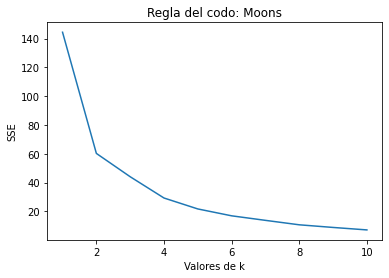

In [11]:
sse = []
for i in np.arange(1,11):                     # Evaluar desde k=1 a k=10
    km = cluster.KMeans(n_clusters=i).fit(X)  # Instanciar K-means y ajustar
    sse.append(km.inertia_)                   # Calcular y registrar el error cuadrático de cada punto a su centroide más cercano

# Graficar
plt.title("Regla del codo: Moons")
plt.xlabel("Valores de k")
plt.ylabel("SSE", rotation=90)
plt.plot(np.arange(1, 11), sse)
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué se interpreta en la gráfica? ¿Cómo podría mejorarse la elección de $k$?.  
</div>

<font color=#679532>A diferencia del caso anterior, el error cuadrático **no presenta un punto de inflexión tan marcado para un valor de *k***. Esto podría ser un indicativo de que, debido a la distribución de los datos, el algoritmo *K-means* pueda no ser tan resolutivo.

<font color=#679532>Del mismo modo, la elección de *k* se podría mejorar calculando la mejora porcentual del error cuadrático para un valor *k* con respecto al error cuadrático para el valor de *k*-1:

[139.6  36.7  50.4  35.   28.2  22.9  28.9  20.7  24.1]


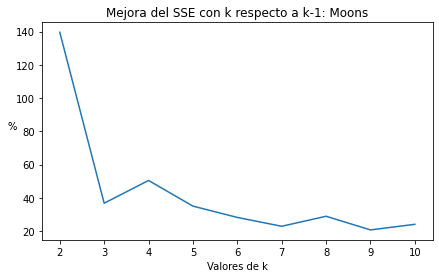

In [12]:
mejora = []
for i in np.arange(1, len(sse)):
    mejora.append(((sse[i-1]-sse[i])/sse[i])*100)  # Calcular y registrar el % de mejora

# Graficar
plt.figure(figsize=(7, 4))
plt.title("Mejora del SSE con k respecto a k-1: Moons")
plt.xlabel('Valores de k')
plt.ylabel('%', rotation=0)
plt.plot(np.arange(2, 11), mejora)
print(np.around(mejora, 1))
plt.show()

<font color=#679532>Esto nos confirma que el algoritmo no es muy eficiente en este conjunto de datos debido a los saltos que se pueden apreciar en la mejora porcentual al aumentar el valor de *k*. Teniendo esto en cuenta, parece que la mejor opción podría ser *k*=4.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> cálculo y visualización de los grupos en el dataset Moons.
</div>

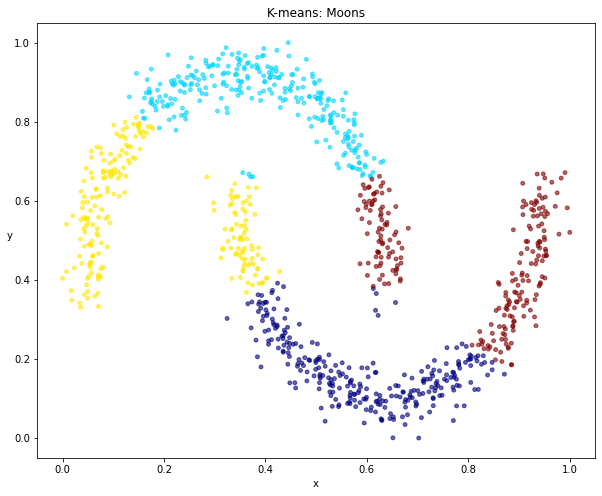

In [13]:
k = 4
km = cluster.KMeans(n_clusters=k).fit(X)                               # Instanciar K-means y ajustar con k=6

# Graficar
plt.figure(figsize=(10, 8))
plt.title("K-means: Moons")
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.scatter(X[:,0], X[:,1], s=15, c=km.labels_, alpha=.6, cmap='jet')  # Establecer como clases las generadas por K-means
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

<font color=#679532>Claramente el algortimo *K-means* no puede categorizar los datos de la forma más intuitiva. Se puede apreciar que la clasificación de los datos por su por cercanía a los centroides hace que muchos **datos que están muy próximos entre sí, y de forma muy densa, pertenezcan a distinas clases**, a la vez que datos de la misma clase están muy separados entre sí. Por lo tanto, la aproximación del algoritmo *K-means* no es adecuada en para este conjunto de datos.

In [14]:
X, y = X_circles, y_circles

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> cálculo y visualización de la regla del codo en el dataset Circles.
</div>

In [15]:
# Normalizar
X = normalizar.fit_transform(X)

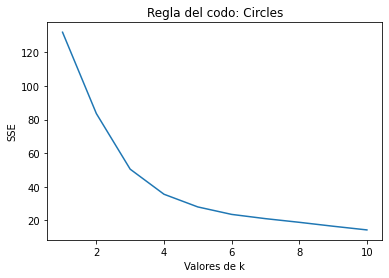

In [16]:
sse = []
for i in np.arange(1,11):                     # Evaluar desde k=1 a k=10
    km = cluster.KMeans(n_clusters=i).fit(X)  # Instanciar K-means y ajustar
    sse.append(km.inertia_)                   # Calcular y registrar el error cuadrático de cada punto a su centroide más cercano

# Graficar
plt.title("Regla del codo: Circles")
plt.xlabel("Valores de k")
plt.ylabel("SSE", rotation=90)
plt.plot(np.arange(1, 11), sse)
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué se interpreta en la gráfica? ¿Cómo podría mejorarse la elección de $k$?.  
</div>

<font color=#679532>Al igual que en el caso anterior, el error cuadrático **no presenta un punto de inflexión marcado para un valor de *k***, lo que dificulta la elección de *k*. Esto vuelve a ser un indicio de que, debido a la distribución de los datos, el algoritmo *K-means* pueda no ser adecuado.

<font color=#679532>Para mejorar la elección de *k*, usar la mejora porcentual del error cuadrático sigue siendo de gran ayuda.

[57.9 65.6 42.  27.  18.9 12.  11.6 14.1 15.4]


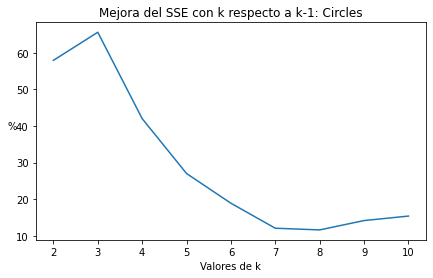

In [17]:
mejora = []
for i in np.arange(1, len(sse)):
    mejora.append(((sse[i-1]-sse[i])/sse[i])*100)  # Calcular y registrar el % de mejora

# Graficar
plt.figure(figsize=(7, 4))
plt.title("Mejora del SSE con k respecto a k-1: Circles")
plt.xlabel('Valores de k')
plt.ylabel('%', rotation=0)
plt.plot(np.arange(2, 11), mejora)
print(np.around(mejora, 1))
plt.show()

<font color=#679532>En términos absolutos, las mejoras relativas son mucho menores que en los dos casos anteriores. Sin embrago, relativamente parece que *k*=5 podría ser la mejor opción.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> cálculo y visualización de los grupos en el dataset Circles.
</div>

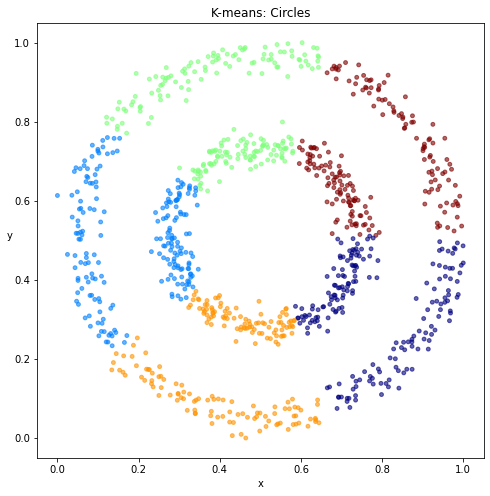

In [18]:
k = 5
km = cluster.KMeans(n_clusters=k).fit(X)                               # Instanciar K-means y ajustar con k=4

# Graficar
plt.figure(figsize=(8, 8))
plt.title("K-means: Circles")
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.scatter(X[:,0], X[:,1], s=15, c=km.labels_, alpha=.6, cmap='jet')  # Establecer como clases las generadas por K-means
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

<font color=#679532>Al igual que con el conjunto de datos *moons*, las agrupaciones por cercanía a los centroides hace que datos densamente cercanos entre sí pertenezcan a distintas clases, mientras que datos muy alejados entre sí sean de la misma clase. Por lo tanto, la aproximación de este algoritmo no es adecuada en este caso.

### 1 b. Algoritmos basados en densidad: DBScan

En este apartado se pide aplicar clustering por densidad como [DBSCAN](https://en.wikipedia.org/wiki/DBSCAN) a los datasets anteriores para detectar los grupos subyacentes.

In [19]:
X, y = X_blobs, y_blobs

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> prueba la implementación de <a href="http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html">DBSCAN en scikit-learn</a> jugando con los parámetros <i>eps</i> y <i>min_samples</i> para encontrar los grupos (y <i>outliers</i>) del dataset Blobs.
</div>

In [20]:
# Normalizar
X = normalizar.fit_transform(X)

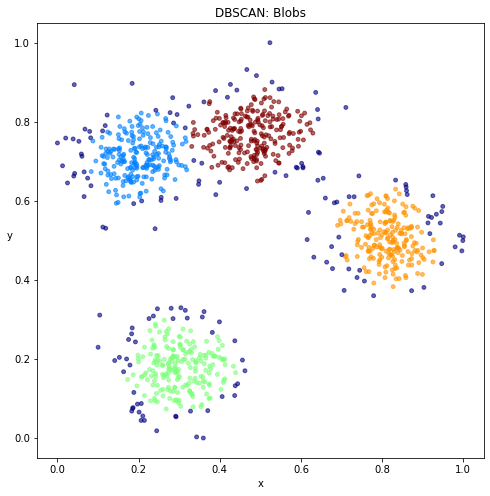

In [21]:
e = .035
m = 12
db = cluster.DBSCAN(eps=e, min_samples=m).fit(X)

# Graficar
plt.figure(figsize=(8, 8))
plt.title("DBSCAN: Blobs")
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.scatter(X[:,0], X[:,1], s=15, c=db.labels_, alpha=.6, cmap='jet')  # Establecer como clases las generadas por DBSCAN
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

<font color=#679532>Al seleccionar la clase de un dato con respecto a los que tiene a su alrededor (jugando con **cuántos** y a **qué distancia** para considerarlos de la misma clase), resulta muy difícil separar los dos *clusters* superiores manteniendo a su vez el resto de agrupaciones homogéneas en la misma agrupación. Esto se debe a que, al haber dos agrupaciones muy juntas, este algoritmo no es capaz de separarlas sin comprometer al resto de agrupaciones que se encuentran más alejadas entre sí.

<font color=#679532>Otra característica de *DBSCAN* es que tampoco es capaz de calsificar los datos que se encuentran relativamente más alejados de su cluster, auqnue estos datos estén absolutamente alejados del resto de agrupaciones. Por lo tanto, dependiendo de los parámetros, y si la densidad de los *clusters* es algo heterogénea, es muy posible que el algoritmo considere *outliers* datos que están muy próximos a una agrupación y muy alejados de otras.

In [22]:
X, y = X_moons, y_moons

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> prueba la implementación de DBScan jugando con los parámetros <i>eps</i> y <i>min_samples</i> para encontrar los grupos (y <i>outliers</i>) del dataset Moons.
</div>

In [23]:
# Normalizar
X = normalizar.fit_transform(X)

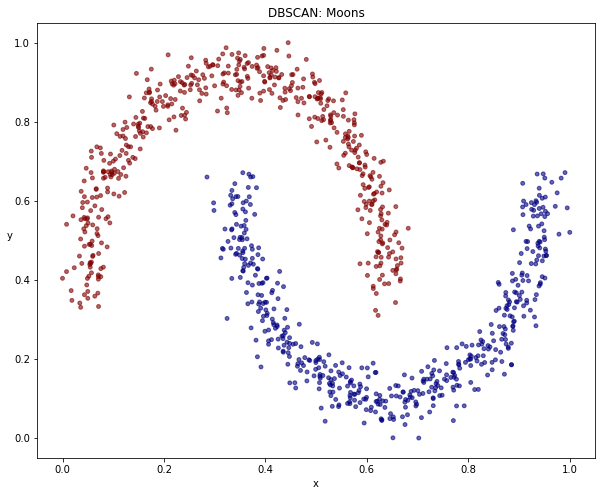

In [24]:
e = .1
m = 3
db = cluster.DBSCAN(eps=e, min_samples=m).fit(X)

# Graficar
plt.figure(figsize=(10, 8))
plt.title("DBSCAN: Moons")
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.scatter(X[:,0], X[:,1], s=15, c=db.labels_, alpha=.6, cmap='jet')  # Establecer como clases las generadas por DBSCAN
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

<font color=#679532>Afinando los parámetros, *DBSCAN* es capaz de **separar acertadamente las distintas agrupaciones, por muy heterogénea que sea su distribución y cuán entrelazadas estén entre sí**. Esto es gracias a que la densidad de los *clusters* es suficiente como para poder separar las clases sin considerar ningún *outlier*.

In [25]:
X, y = X_circles, y_circles

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> prueba la implementación de DBScan jugando con los parámetros <i>eps</i> y <i>min_samples</i> para encontrar los grupos (y <i>outliers</i>) del dataset Circles.
</div>

In [26]:
# Normalizar
X = normalizar.fit_transform(X)

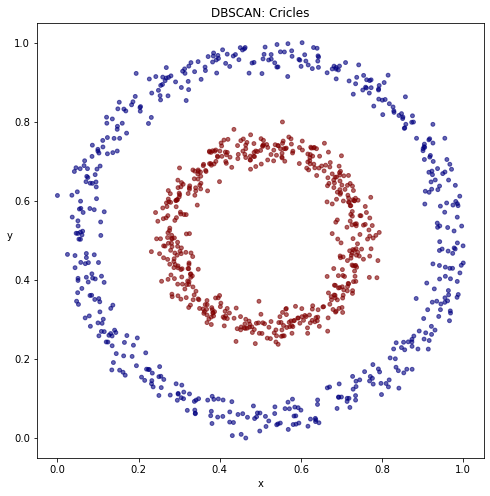

In [27]:
e = .11
m = 50
db = cluster.DBSCAN(eps=e, min_samples=m).fit(X)

# Graficar
plt.figure(figsize=(8, 8))
plt.title("DBSCAN: Cricles")
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.scatter(X[:,0], X[:,1], s=15, c=db.labels_, alpha=.6, cmap='jet')  # Establecer como clases las generadas por DBSCAN
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

<font color=#679532>Exactamente igual que en el caso anterior: al estar definidas las agrupaciones principalmente por su densidad homogénea, este algoritmo puede separarlas perfectamente sin considerar outliers, independientemente de la forma que tenga la distribución del *cluster*.

### 1 c. Algoritmos jerárquicos

En este apartado se pide visualizar mediante un [dendrograma](https://en.wikipedia.org/wiki/Dendrogram) la construcción progresiva de los grupos mediante un algoritmo jerárquico aglomerativo (estrategia *bottom-up*). Con ello se pretende encontrar un método gráfico para entender el comportamiento del algoritmo y encontrar los *clusters* deseados en cada dataset.

In [28]:
X, y = X_blobs, y_blobs

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> prueba la implementación de <a href="https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html">clustering jerárquico de scipy</a> probando distintos <a href="https://en.wikipedia.org/wiki/Hierarchical_clustering#Linkage_criteria">criterios de enlace o <i>linkage</i></a> permitiendo identificar los clusters subyacentes (mostrando su resultado) y su dendrograma para el dataset Blobs.<br>
Puedes importar las librerías necesarias para ello.
</div>

In [29]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

In [30]:
# Normalizar
X = normalizar.fit_transform(X)

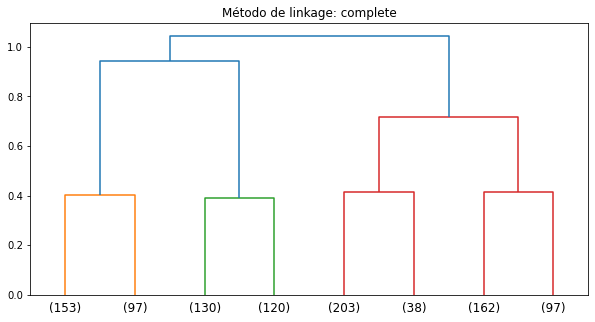

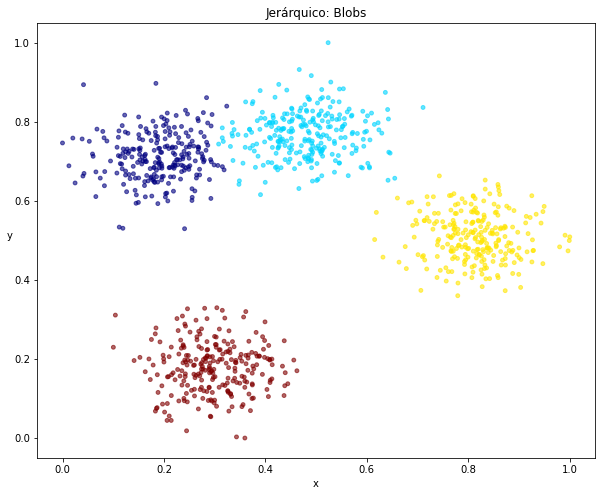

In [31]:
metodo = 'complete'
linked = linkage(X, metodo)
plt.figure(figsize=(10, 5))
dendrogram(linked,
            p=2,
            truncate_mode='level',
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=True)
plt.title("Método de linkage: " + metodo)
plt.show()

cl = AgglomerativeClustering(n_clusters=4, linkage='complete').fit(X)  # Instanciar y ajustar el modelo

# Graficar
plt.figure(figsize=(10, 8))
plt.title("Jerárquico: Blobs")
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.scatter(X[:,0], X[:,1], s=15, c=cl.labels_, alpha=.6, cmap='jet')
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> Interpreta el dendrograma y comenta qué criterio de enlace se ha comportado mejor. ¿Por qué?
</div>

<font color=#679532>Probando diferentes métodos de *linkage*, el resultado final varía sensiblemente en cómo separa los dos *clusters* superiores. No obstante, casi todos demuestran una gran resolución a la hora de realizar las agrupaciones, obteniendo resultados muy parecidos a los de *K-means* para este conjunto de datos.

En cuanto al dendograma, se aprecia la similitud entre los *clusters* superiores ya que cuesta más separarlos (en el dendograma, la primera división de la rama roja a la derecha) en comparación con los otros dos (rama azul a la izquierda).

In [32]:
X, y = X_moons, y_moons

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
prueba la implementación de <a href="https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html">clustering jerárquico de scipy</a> probando distintos <a href="https://en.wikipedia.org/wiki/Hierarchical_clustering#Linkage_criteria">criterios de enlace o <i>linkage</i></a> permitiendo identificar los clusters subyacentes (mostrando su resultado) y su dendrograma para el dataset Moons.<br>
Puedes importar las librerías necesarias para ello.
</div>

In [33]:
# Normalizar
X = normalizar.fit_transform(X)

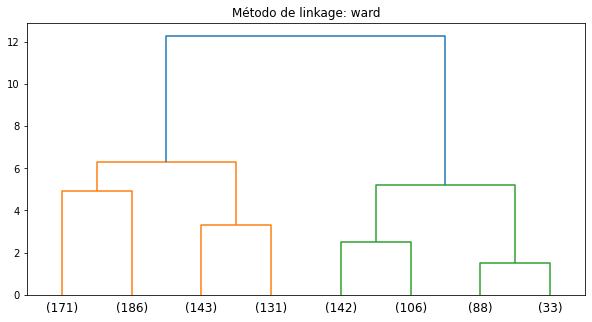

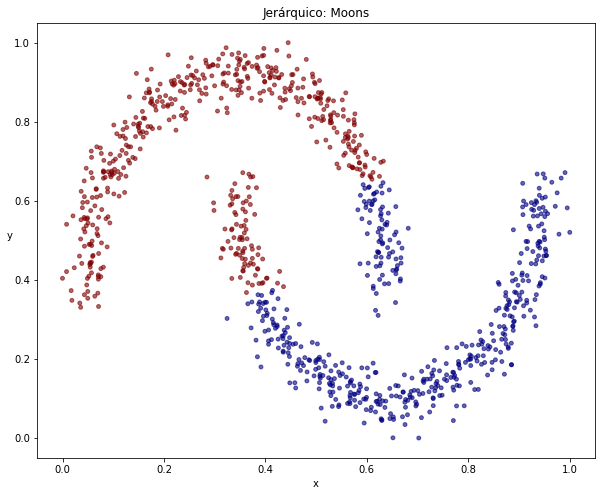

In [34]:
metodo = 'ward'
linked = linkage(X, metodo)
plt.figure(figsize=(10, 5))
dendrogram(linked,
            p=2,
            truncate_mode='level',
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=True)
plt.title("Método de linkage: " + metodo)
plt.show()

cl = AgglomerativeClustering(n_clusters=2, linkage='complete').fit(X)  # Instanciar y ajustar el modelo

# Graficar
plt.figure(figsize=(10, 8))
plt.title("Jerárquico: Moons")
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.scatter(X[:,0], X[:,1], s=15, c=cl.labels_, alpha=.6, cmap='jet')
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> Interpreta el dendrograma y comenta qué criterio de enlace se ha comportado mejor. ¿Por qué?
</div>

<font color=#679532>Al establecer el número de *clusters* como 2, todos los métodos de *linkage* obtienen practicamente los mismo resultados. Debido a la aproximación de este algoritmo y a la distribución particular de estos datos, éste no es capaz de separar las agrupaciones de forma tan acertada como los algoritmos de densidad (*DBSCAN*).

In [35]:
X, y = X_circles, y_circles

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
prueba la implementación de <a href="https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html">clustering jerárquico de scipy</a> probando distintos <a href="https://en.wikipedia.org/wiki/Hierarchical_clustering#Linkage_criteria">criterios de enlace o <i>linkage</i></a> permitiendo identificar los clusters subyacentes (mostrando su resultado) y su dendrograma para el dataset Circles.<br>
Puedes importar las librerías necesarias para ello.
</div>

In [36]:
# Normalizar
X = normalizar.fit_transform(X)

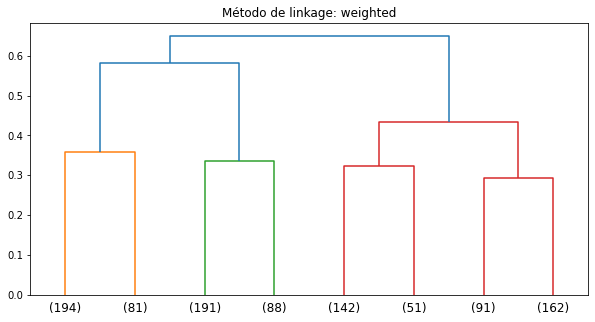

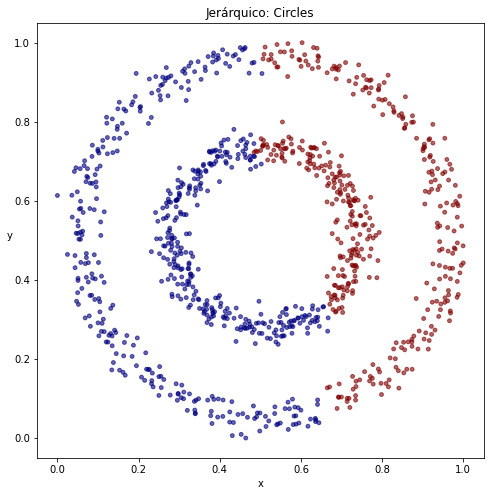

In [37]:
metodo = 'weighted'
linked = linkage(X, metodo)
plt.figure(figsize=(10, 5))
dendrogram(linked,
            p=2,
            truncate_mode='level',
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=True)
plt.title("Método de linkage: " + metodo)
plt.show()

cl = AgglomerativeClustering(n_clusters=2, linkage='complete').fit(X)  # Instanciar y ajustar el modelo

# Graficar
plt.figure(figsize=(8, 8))
plt.title("Jerárquico: Circles")
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.scatter(X[:,0], X[:,1], s=15, c=cl.labels_, alpha=.6, cmap='jet')
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> Interpreta el dendrograma y comenta qué criterio de enlace se ha comportado mejor. ¿Por qué?
</div>

<font color=#679532>Al igual que en el caso anterior, esta distribución de los datos no es adecuada desde el punto de vista de este algoritmo. Los dos *clusters* no son divididos correctamente independientemente del método de *linkage* utilizado, ya que al establecer 2 *clusters* siempre se obtiene el mismo resultado.

<a id="ej2"></a>

## 2. Aplicación: generación de imágenes con reducción de dimensionalidad (3 puntos)

Es posible aplicar una amplia variedad de algoritmos para la reducción de dimensionalidad. Para ello se empleará el dataset MNIST compuesto de miles de dígitos manuscritos del 0 al 9. Donde cada imagen se compone de 784 píxeles (imágenes de 28 x 28), por lo que se parte de un número alto de dimensiones.

In [38]:
X, y = sklearn.datasets.fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

Por lo que cada muestra (las 70k filas del dataset) se componen de 784 dimensiones:

In [39]:
X.shape

(70000, 784)

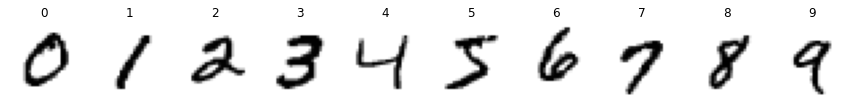

In [40]:
fig, axis = plt.subplots(1, 10, figsize=(12, 6))
for i, ax in enumerate(axis):
    ax.imshow(X[y == str(i)][0].reshape(28, 28), cmap='gray_r')
    ax.set_title(str(i))
    ax.axis('off')
plt.tight_layout()

Si cada algoritmo obtiene resultados distintos a la hora de reducir la dimensionalidad, ¿qué representación es más fiel a la distribución original?

Antes de reducir las 784 dimensiones originales de cada muestra a 2 para poder visualizarlas en 2 dimensiones, es muy útil conocer, o al menos intuir, la estructura en alta dimensionalidad de los datos.

Para ello se puede hacer uso del dendrograma como heurística para conocer la disposición original de los datos y comprobar si la proyección es similar a lo mostrado por el dendrograma.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> aprender una proyección a 2 dimensiones de las muestras de X con <a href="https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html">PCA</a> y proyectar el conjunto X a dos dimensiones. Después visualizarlo en un scatter plot.

Utiliza las etiquetas de y (el número manuscrito al que se corresponde cada muestra), en el parámetro label (en la llamada a scatter) y la función legend en la visualización para saber la clase correspondiente a cada punto e interpretar el resultado de la reducción de dimensionalidad y poder interpretar el resultado de la proyección.
</div>

In [41]:
# Normalizar
X = normalizar.fit_transform(X)

In [42]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)  # Instanciar PCA con n_components = 2
Xpca = pca.fit_transform(X)  # Ejecutar PCA
Xpca.shape

(70000, 2)

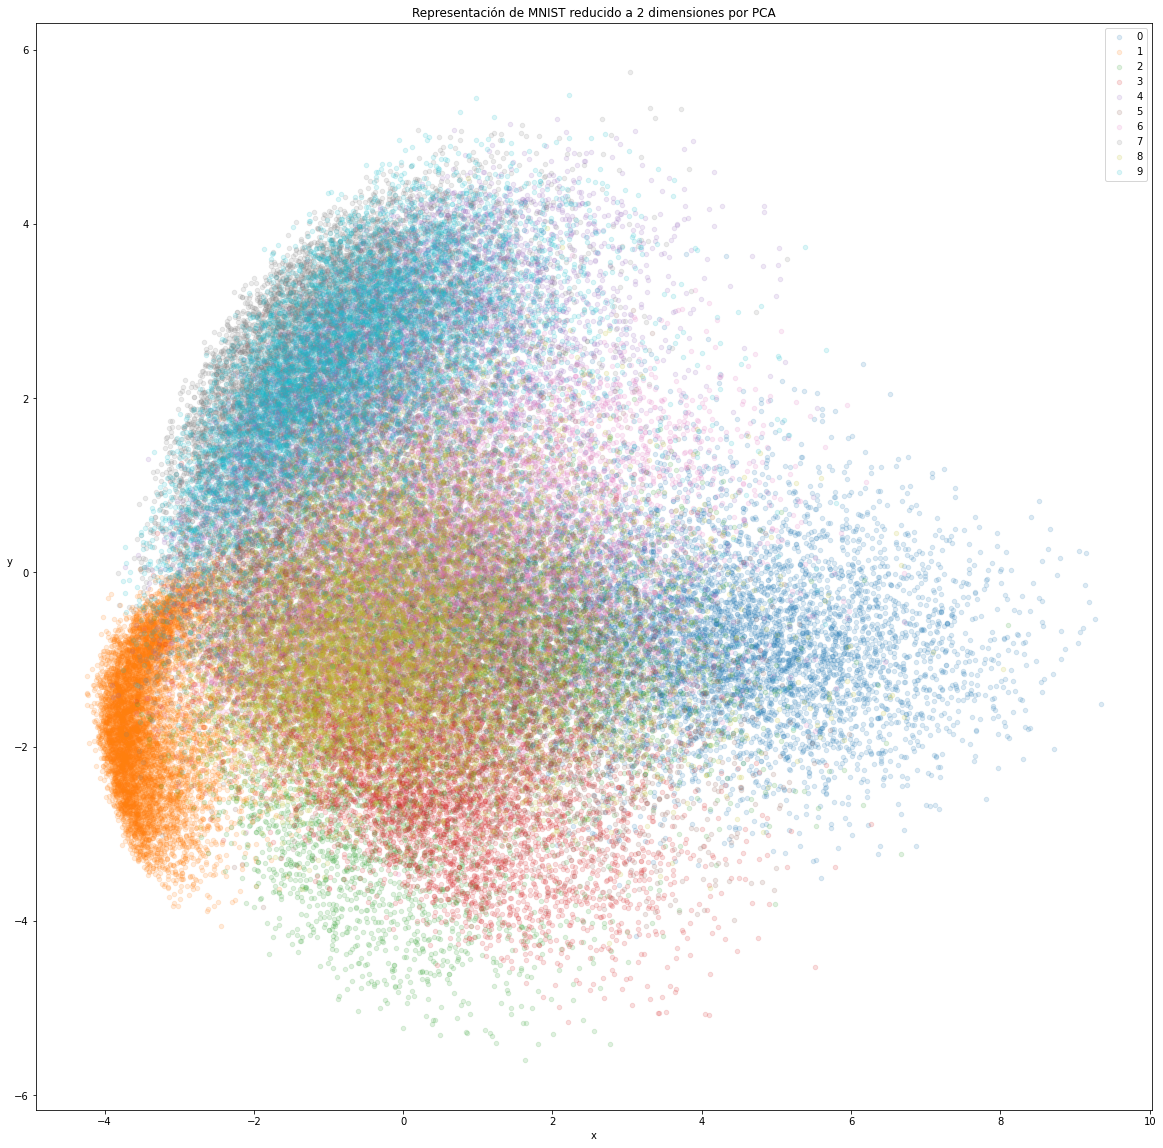

In [43]:
plt.figure(figsize=(20, 20))
plt.title('Representación de MNIST reducido a 2 dimensiones por PCA')

# Graficar los puntos de Xpca según su clase
for i in np.unique(y):
    plt.scatter(Xpca[np.where(y==i)[0], 0], Xpca[np.where(y==i)[0], 1], s=20, alpha=.15, label=i)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend()
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué puedes interpretar de la proyección? ¿Las clases han quedado visiblemente separadas? ¿Por qué?
</div>

<font color=#679532>Auqnue se pueden diferenciar algunas zonas donde se agrupan los puntos de una misma clase, por ejemplo la clase *1*, existe **mucha superposición** de forma muy generalizada en la distribución de los datos pertenecientes a cada clase, por lo que no se pueden distinguir visualmente.

En la gráfica anterior cada punto representa una muestra en 2 dimensiones. Con PCA es posible <a href="https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA.inverse_transform">invertir la transformación</a> para que, a partir de cada punto 2d, se obtenga de nuevo (aproximadamente) la imagen original (784 dimensiones).

Por lo que es posible "generar" nuevas imágenes eligiendo puntos aleatoriamente del plano 2d, y pedirle al modelo PCA aprendido que invierta la transformación para obtener las "teóricas" imágenes que habrían sido proyectadas a esos puntos del espacio proyectado.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> calcular el máximo y mínimo de cada una de las dos dimensiones y, para cada una de ellas, <a href="https://numpy.org/doc/stable/reference/generated/numpy.linspace.html">generar una secuencia</a> de 10 valores con igual separación.
</div>

In [44]:
xsec = np.linspace(min(Xpca[:, 0]), max(Xpca[:, 0]), num=10)  # Secuencia dimensión x
ysec = np.linspace(min(Xpca[:, 1]), max(Xpca[:, 1]), num=10)  # Secuencia dimensión y

Con las dos secuencias de 10 (una por cada dimensión del plano de proyección) valores es posible combinar los puntos de ambas secuencias para generar 100 combinaciones (puntos 2d) que teselan el plano sobre el que PCA ha proyectado las muestras.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> invertir la transformación para cada uno de los 100 puntos y visualizar su imagen asociada en una matriz de 10 x 10 imágenes (tratando de preservar su posición en el espacio proyectado).
</div>

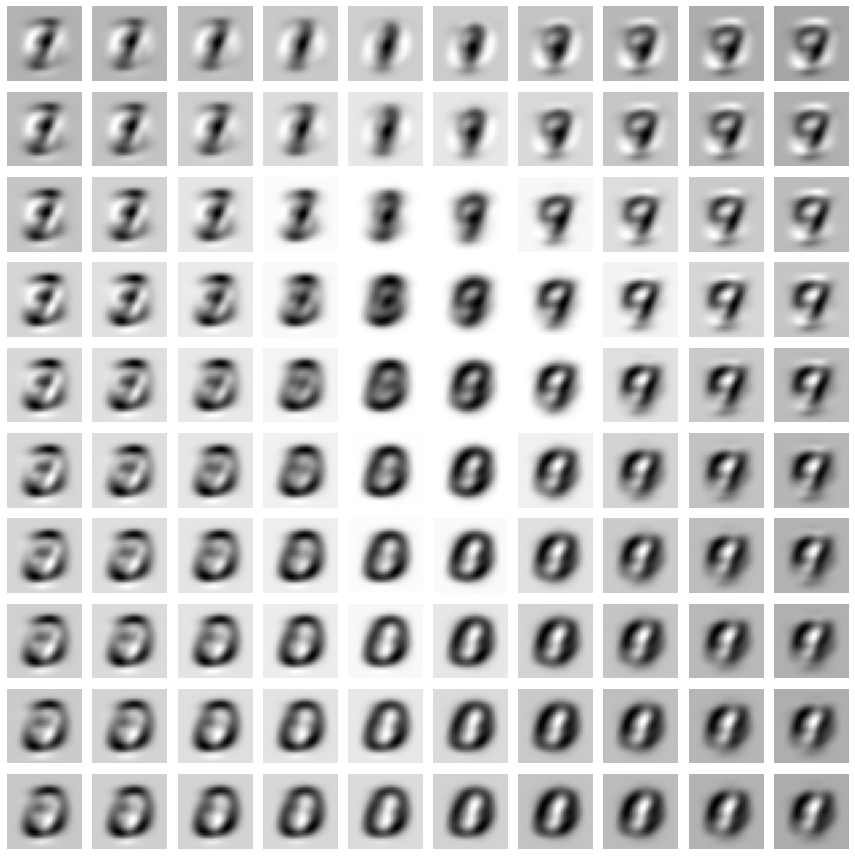

In [45]:
# Crear los 100 puntos combinando entre sí los 10 valores de las 2 dimensiones
newsec = []
for i in range(len(xsec)):
    for j in range(len(ysec)):
        newsec.append([xsec[i], ysec[j]])

# Invertir la transformación PCA con los 100 puntos
Xinverted = pca.inverse_transform(newsec)

# Visualizar
fig, axis = plt.subplots(10, 10, figsize=(12, 12))
k = 0
for i, ax in enumerate(axis):
    for j in range(len(ax)):
        ax[j].imshow(Xinverted[k,:].reshape(28, 28), cmap='gray_r')
        ax[j].axis('off')
        k=k+1
plt.tight_layout()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué puedes interpretar de las imágenes reconstruidas / interpoladas? ¿Genera números o transiciones entre números visualmente creíbles? ¿Por qué?
</div>

<font color=#679532>Existe mucho **ruido** en las imágenes provocado por la tranformación inversa de *PCA*. Sin embargo, pueden llegar a distinguirse algunas transiciones entre números como el *1*, *7*, *3*, *8* y *9*.

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Podría haberse conseguido lo mismo con <a href="https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html">t-SNE</a>? ¿Por qué?
</div>

<font color=#679532>Probablemente no, ya que *t-SNE* genera un representación en 2D de la distribución de los datos según su clase interpretando todas las dimensiones iniciales de forma diferente a como lo hace *PCA*: *t-SNE* se centra en interpretar los datos con el objetivo de representar en 2D su **distribución** intrínseca sin preservar la estructura global, mientras que *PCA* se centra en interpretar los datos en una dimensionalidad reducida con el objetivo de maximizar la varianza del conjunto (su **información** intrínseca).

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> aprender una proyección a 2 dimensiones de las muestras de X con <a href="https://towardsdatascience.com/how-exactly-umap-works-13e3040e1668">UMAP</a> (con los parámetros por defecto) usando la librería <a href="https://umap-learn.readthedocs.io/en/latest/">umap-learn</a> y proyectar el conjunto X a dos dimensiones. Después visualizarlo en un scatter plot.

Utiliza las etiquetas de y (el número manuscrito al que se corresponde cada muestra), en el parámetro label (en la llamada a scatter) y la función legend en la visualización para saber la clase correspondiente a cada punto e interpretar el resultado de la reducción de dimensionalidad y poder interpretar el resultado de la proyección.
</div>

In [59]:
import umap

UMAP = umap.UMAP()             # Instanciar UMAP
Xumap = UMAP.fit_transform(X)  # Ejecutar y ajustar UMAP

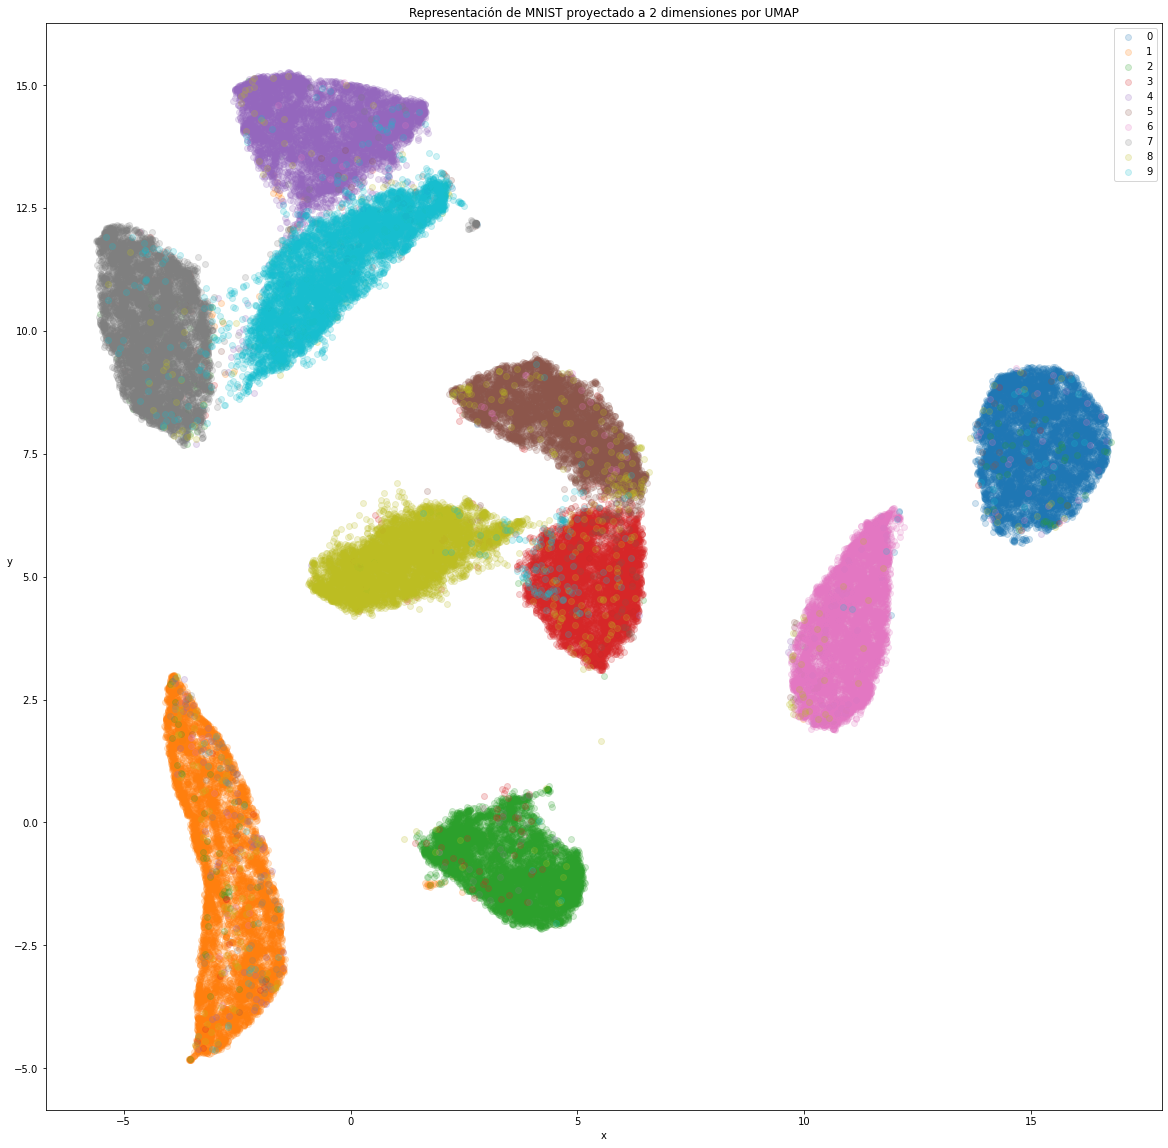

In [60]:
# Graficar los puntos de Xumap según su clase
plt.figure(figsize=(20, 20))
plt.title('Representación de MNIST proyectado a 2 dimensiones por UMAP')
for i in np.unique(y):
    plt.scatter(Xumap[np.where(y==i)[0], 0], Xumap[np.where(y==i)[0], 1], alpha=.2, label=i)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend()
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué puedes interpretar de la proyección? ¿Las clases han quedado visiblemente separadas? ¿Por qué?
</div>

<font color=#679532>Aunque algunos puntos han sido mal clasificados, todas las clases han quedado perfectamente separadas entre sí gracias a la gran capacidad del algortimo de preservar muy bien la estrucutra inicial de los datos. Esto puede deberse a que *UMAP* utiliza una distribución de probabilidad exponencial en dimensiones altas, por lo que puede conectar cualquier distancia entre datos; además de usar *n_neighbos*, lo que también ayuda a mantener la estructura original.

<font color=#679532>https://ichi.pro/es/como-funciona-exactamente-umap-21865746536040

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> al igual que anteriormente con PCA, calcula el máximo y mínimo para cada una de las dos dimensiones e invierte la transformación con el modelo aprendido por UMAP para cada uno de los 100 puntos y visualizar su imagen asociada en una matriz de 10 x 10 imágenes (tratando de preservar su posición en el espacio proyectado).
    
<strong>Consejo</strong>: la inversión de la transformación en UMAP es más costosa computacionalmente que con PCA, por lo que recomiendo que sólo la invoques una vez con las 100 muestras en lugar de hacer 100 llamadas (una por cada muestra). Esto reduce drácticamente el tiempo de ejecución.
</div>

In [61]:
xsec = np.linspace(min(Xumap[:, 0]), max(Xumap[:, 0]), num=10)  # Secuencia dimensión x
ysec = np.linspace(min(Xumap[:, 1]), max(Xumap[:, 1]), num=10)  # Secuencia dimensión y

# Crear los 100 puntos combinando entre sí los 10 valores de las 2 dimensiones
newsec = []
for i in range(len(xsec)):
    for j in range(len(ysec)):
        newsec.append([xsec[i], ysec[j]])

# Invertir la transformación UMAP con los 100 puntos
Xinverted = UMAP.inverse_transform(newsec)

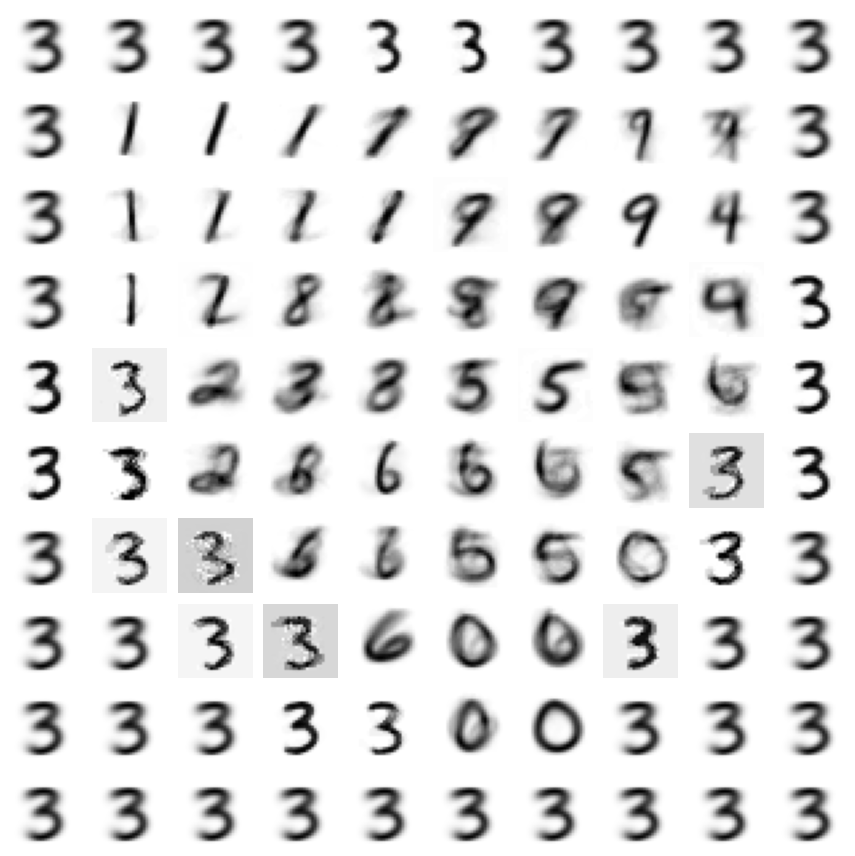

In [62]:
# Visualizar
fig, axis = plt.subplots(10, 10, figsize=(12, 12))
k = 0
for i, ax in enumerate(axis):
    for j in range(len(ax)):
        ax[j].imshow(Xinverted[k,:].reshape(28, 28), cmap='gray_r')
        ax[j].axis('off')
        k=k+1
plt.tight_layout()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué puedes interpretar de las imágenes reconstruidas / interpoladas? ¿Genera números o transiciones entre números visualmente creíbles? ¿Por qué?
</div>

<font color=#679532>La nitidez y el ruido ha mejorado drásticamente con respecto al método *PCA*. Se pueden identificar perfectamente todos los números reconstruidos, auqnue algunos de ellos no están del todo definidos. La aproximación de *UMAP* al crear primero un grafo multidimensional "*fuzzy*" ponderado hace que, al proyectarlo posteriormente a dos dimensiones, los datos conserven gran parte de la estructura inicial localmente, por lo que al aplicarlo a datos nuevos hace que la reconstrucción sea muy acertada.
    
<font color=#679532>https://pair-code.github.io/understanding-umap/

<a id="ej3"></a>

## 3. Aplicación: identificación de puntos de interés turísticos (3 puntos)

En este ejercicio se busca automatizar la localización de lugares turísticos a través de los metadatos de las fotografías de flickr.

Para ello se provee junto a la PEC el dataset: ``barcelona.csv``. Ya que se pide encontrar los puntos de mayor interés turístico de esta ciudad.

**Opcional: si quieres hacerlo para otra región**

Pero si quieres hacerlo para otra parte del mundo, puedes descargarte el dataset completo [aquí](https://drive.google.com/file/d/0B-mRR4rjwHPONVFfX2VmTmxZcHM/view?usp=sharing) y descomprime para extraer el *CSV*.

Para seleccionar las coordenadas de la zona de interés puedes usar la opción *Export* manual de [OpenStreetMaps](https://www.openstreetmap.org/).

Por último, para filtrar los datos que se corresponden a la zona deseada puedes usar el programa *AWK* mediante la siguiente línea:

``awk -F"," 'NR == 1 {print $5","$6} (NR > 1 && $5 > 41.3560 && $5 < 41.4267 && $6 > 2.1300 && $6 < 2.2319) {print $5","$6}' photo_metadata.csv``

``$5`` hace referencia a la latitud, y ``$6`` a la longitud. Sustituye los valores mínimo y máximo para obtener los datos de localización referentes a tu área de interés.

In [50]:
geo_df = pd.read_csv('barcelona.csv', header=0)
geo_df.sample(5)

latitude  longitude
1279   41.388384   2.198359
4454   41.387796   2.170250
14748  41.404215   2.193617
6728   41.374763   2.170271
4432   41.404083   2.201616

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> siempre que tratamos un problema real, es necesario entender los datos a tratar. Visualiza las localizaciones de las fotografías mediante un scatter plot. Prueba distintos parámetros de tamaño (<i>size</i>) <i>s</i>, y opacidad <i>alpha</i> hasta conseguir un resultado fácil de interpretar. 
</div>

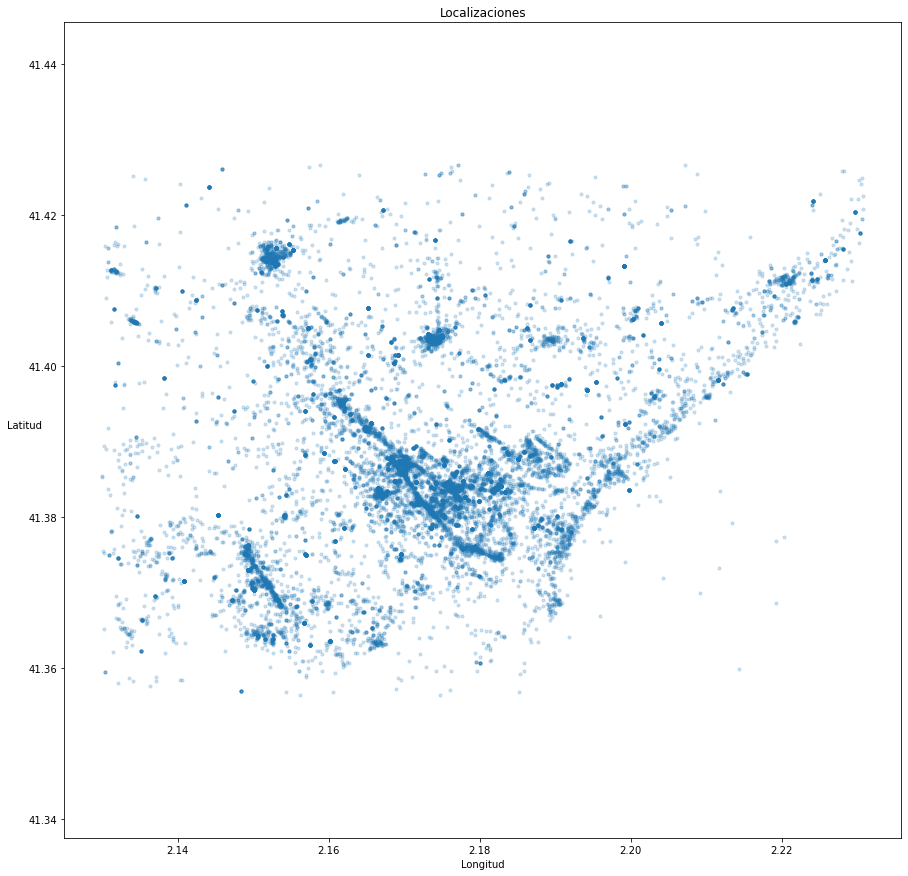

In [51]:
# Graficar
plt.figure(figsize=(15, 15))
plt.title("Localizaciones")
plt.xlabel('Longitud')
plt.ylabel('Latitud', rotation=0)
plt.axis('equal')
plt.scatter(geo_df['longitude'], geo_df['latitude'], s=10, alpha=.2)
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> tras haber probado los algoritmos de agrupamiento en el ejercicio 1. ¿Qué algoritmo crees que sería más adecuado tras visualizar los datos? ¿Por qué?
</div>

<font color=#679532>Debido a la densidad y el ruido de los datos, parece que el método que mejor se puede adaptar es ***DBSCAN***. Las diferentes zonas de densidades no van a ser bien interpretadas por *K-means* ni por el agrupamiento jerárquico, ya que la heterogeneidad de la densidad de los agrupamientos no va a poder ser representada con estos últimos, además de la gran cantidad de outliers.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> para prototipar el modelado primero se recomienda elegir un subconjunto de los datos que sea representativo. Selecciona una muestra del DataFrame original y visualiza como en el punto anterior para comprobar su similitud. 
</div>

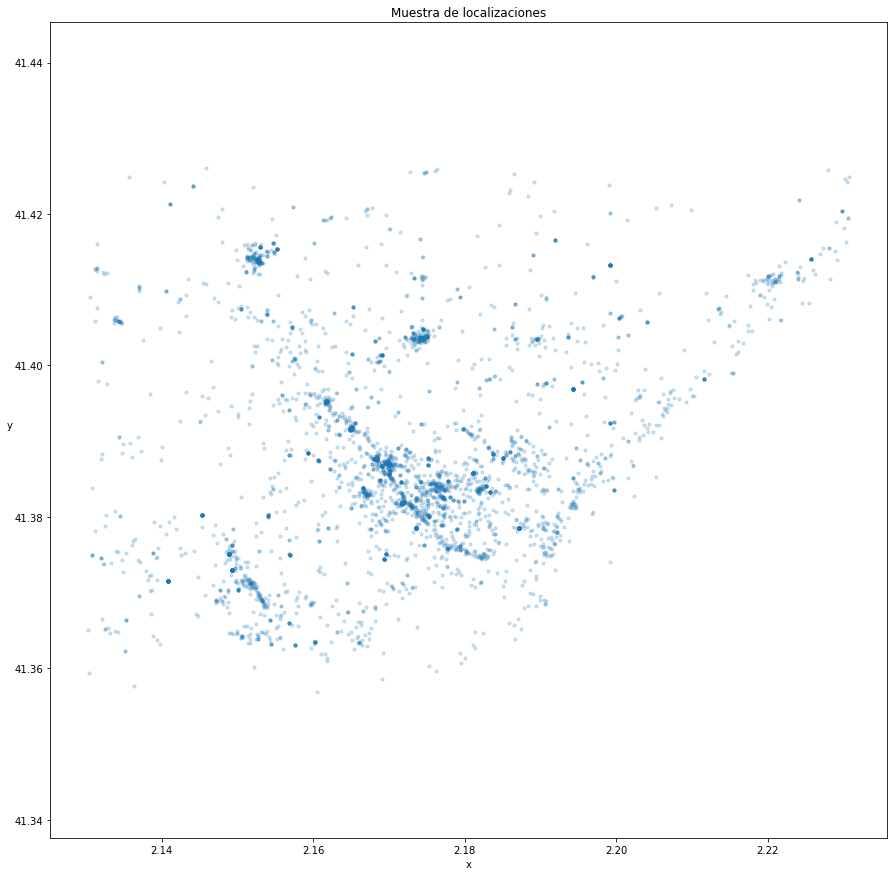

In [52]:
# Generar muestra
geo_df_muestra = geo_df.sample(n=int(geo_df.shape[0]*.2),random_state=1)  # Tamaño de la muestra = 20% del original

# Graficar
plt.figure(figsize=(15, 15))
plt.title("Muestra de localizaciones")
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.axis('equal')
plt.scatter(geo_df_muestra['longitude'], geo_df_muestra['latitude'], s=10, alpha=.2)
plt.show()

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> ajusta el algoritmo de clustering elegido para encontrar los distintos grupos sobre el conjunto reducido, y visualiza el resultado coloreando cada punto en base al grupo al que pertenece. Como pista, alrededor de 20 clusters es un número razonable, y es posible darles un color distinto a cada uno con el <i>colormap: tab20</i>.
</div>

In [53]:
# Normalizar
geo_n = normalizar.fit_transform(geo_df_muestra)
geo_df_muestra = pd.DataFrame(geo_n, columns=geo_df_muestra.columns)

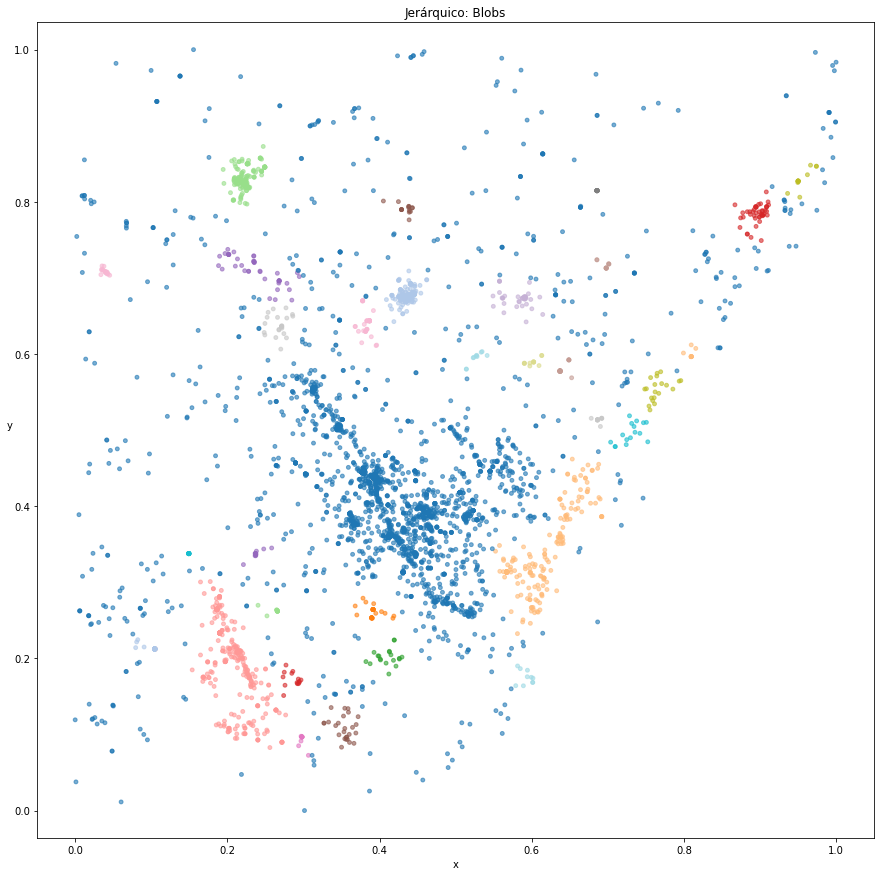

In [54]:
e = .02
m = 10
db = cluster.DBSCAN(eps=e, min_samples=m).fit(geo_df_muestra)

# Graficar
plt.figure(figsize=(15, 15))
plt.title("Jerárquico: Blobs")
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.axis('equal')
plt.scatter(geo_df_muestra['longitude'], geo_df_muestra['latitude'], s=15, c=db.labels_, alpha=.6, cmap='tab20')
plt.show()

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> si has usado un método de <i>clustering</i> que permite la detección de <i>outliers</i>. Representa sólo los puntos que no ha considerado <i>outliers</i>, es decir, los que pertenecen a algún <i>cluster</i>.
</div>

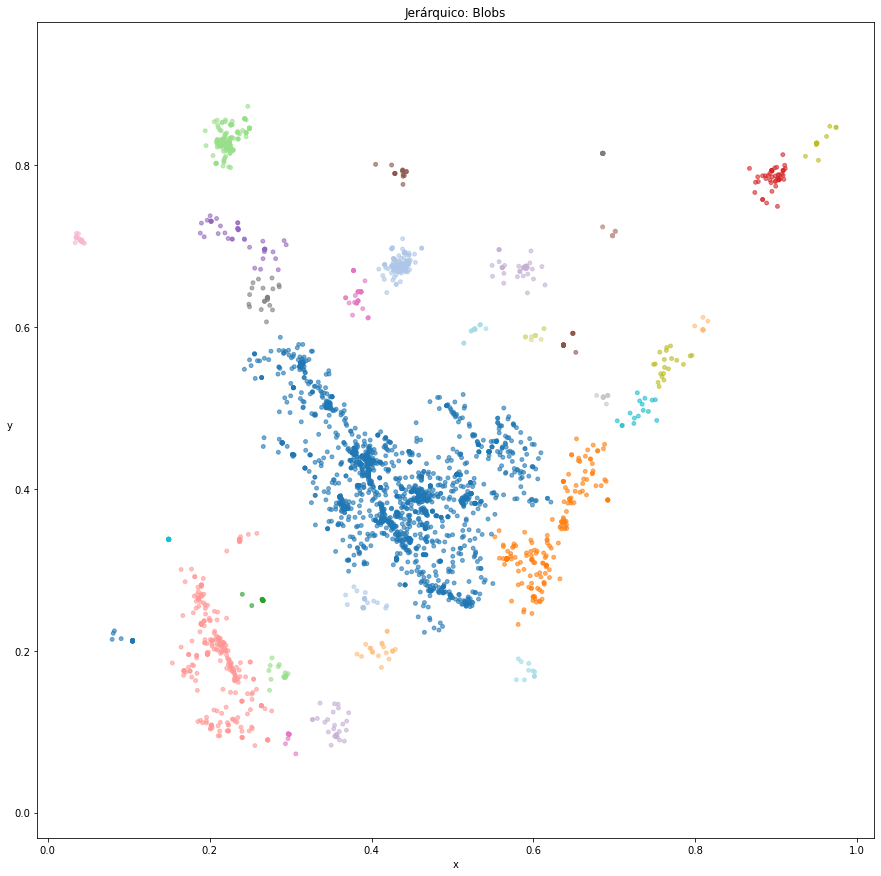

In [55]:
geo_df_muestra_limpio = geo_df_muestra.loc[db.labels_!=-1]  # Eliminar outliers (clase=-1)
etiquetas = db.labels_[db.labels_ != -1]                    # Conservar solo etiquetas de clusters

# Graficar
plt.figure(figsize=(15, 15))
plt.title("Jerárquico: Blobs")
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.axis('equal')
plt.scatter(geo_df_muestra_limpio['longitude'], geo_df_muestra_limpio['latitude'], s=15, c=etiquetas, alpha=.6, cmap='tab20')
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> interpreta cual es el lugar que representa cada <i>cluster</i> (si encuentras una asociación lógica).
</div>

Lugares interpretables a simple vista:
- Parc Güel (NO, verde)
- Gràcia (NO, morado)
- Sagrada Familia (N, gris)
- Plaça de les Glòries Catalanes (N, morado)
- Port Forum (NE, rojo)
- Playa de la Nova Mar Bella (E, gris)
- Playa de la Mar Bella (E, turquesa)
- Eixample (centro, azul)
- Puerto (E, naranja)
- La Barceloneta (SE, azul claro)
- Sants-Montjuïc (SO, rojo)

<div class="alert alert-block alert-info">
<strong>OPCIONAL Implementación:</strong> representa los puntos sin ruido sobre un mapa utilizando la librería <a href="https://pypi.org/project/smopy/">Smopy</a>. Para facilitar la interpretación, puedes representar cada cluster como el punto medio de todos los puntos que lo conforman.
</div>

In [56]:
import smopy

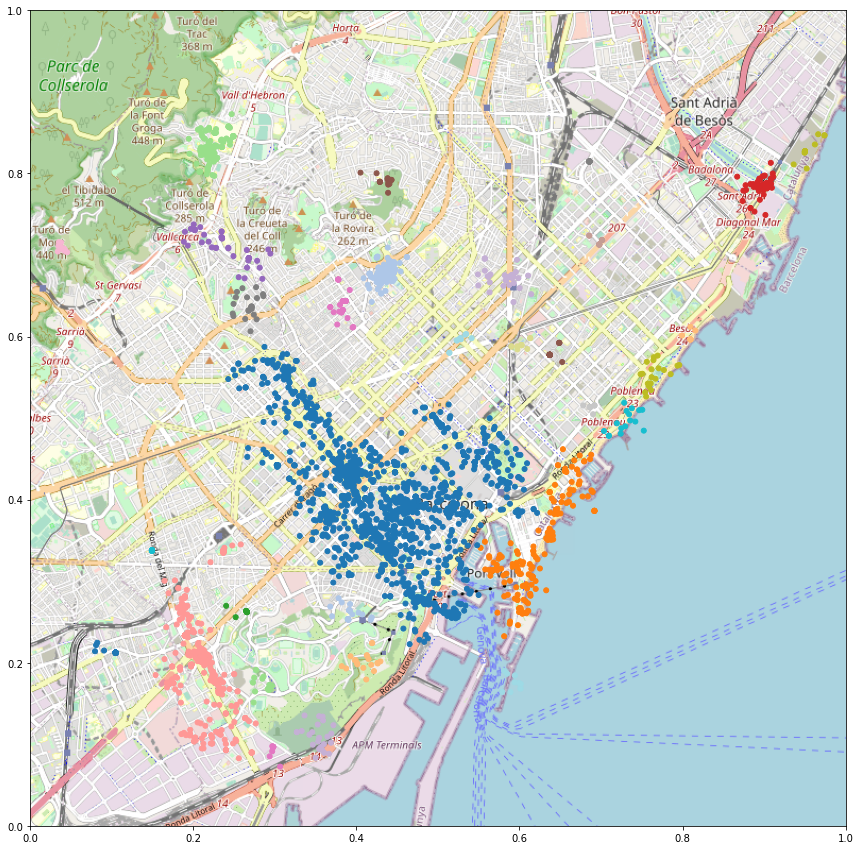

In [57]:
# Generar imagen del mapa con las coordenadas del dataset
map = smopy.Map(min(geo_df['latitude']), min(geo_df['longitude']), max(geo_df['latitude']), max(geo_df['longitude']), z=13)
plt.figure(figsize=(15, 15))
plt.imshow(map.to_numpy(), extent=[min(geo_df_muestra['longitude']), max(geo_df_muestra['longitude']), min(geo_df_muestra['latitude']), max(geo_df_muestra['latitude'])])

# Graficar puntos de la muestra sin outliers
plt.scatter(geo_df_muestra_limpio['longitude'], geo_df_muestra_limpio['latitude'], s=25, c=etiquetas, alpha=1, cmap='tab20')
plt.show()